<a href="https://colab.research.google.com/github/rymuelle/prediction_tracker_ncaaf_predictions/blob/main/investigating_win_prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can ignore this stuff, we are just initilizing some things:

In [66]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [67]:
url="https://raw.githubusercontent.com/rymuelle/prediction_tracker_ncaaf_predictions/main/line_dataframe.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))
df['mov'] = df.hscore - df.vscore

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
def gauss(x,norm, sigma, mean):
  return norm*np.exp(-(x-mean)**2/(2*sigma**2))

The goal of this notebook is to understand how vegas lines relate to win %. Our first step is just to look at MOV and lines and understand what our data looks like:

In [69]:
df.head()

,Unnamed: 0,home,road,line,linesag,linescrp,linemass,linedunk,linepfz,lineperry,linemore,linesea,linemars,lineray,lineargh,linecpa,linehow,linecoll,linegupt,lineed,lineharm,linefrez,linefly,linebihl,linemont,linetsr,lineavg,lineelo,linebill,linebmc,lineswt,lineborn,linem2,lineroth,linecpa2,linemaxy,linewolf,linebass,vscore,date,...,linepivint,linesid,linemidweek,linefeng,linefremeau,linepimean,linepibias,linecurry,linedonchess,linemassey,linemoore,linethocal,linethoavg,linesaggm,linenscombo,linethoats,linemds,linehorobik,linenseye,lineclean,lineespn,linepp,linecrunch,linesagr,linefpi,lineteamrank,linelabr,linebc2,lineround,linefei,linetalis,phcover,phwin,linejens,linepaynep,linepaynewl,lineharville,linegiddens,lineunion,mov
0,0,BYU,Tulane,9.5,11.56,7.47,9.99,7.4,8.44,-1.84,3.12,NaN,6.0,9.1,12.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.95,NaN,NaN,11.0,5.34,5.1,NaN,NaN,NaN,NaN,NaN,NaN,35.0,25/08/01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0
1,1,Colorado,Fresno St.,10.0,10.60,5.99,10.74,1.9,3.70,1.26,9.15,NaN,-2.0,3.5,11.0,5.4,6.5,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,5.92,NaN,NaN,9.0,12.07,10.1,NaN,NaN,NaN,NaN,NaN,NaN,24.0,26/08/01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
2,2,Georgia Tech,Syracuse,9.5,3.41,6.38,0.51,8.2,1.84,-8.46,8.45,NaN,8.0,7.7,9.0,10.4,5.5,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,6.86,NaN,NaN,11.0,22.97,6.2,NaN,NaN,NaN,NaN,NaN,NaN,7.0,26/08/01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,3,Louisville,New Mexico St.,20.0,20.84,19.47,18.17,22.3,10.57,45.92,26.00,NaN,22.0,26.4,22.0,22.9,22.0,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,23.30,NaN,NaN,19.0,20.58,26.7,NaN,NaN,NaN,NaN,NaN,NaN,24.0,23/08/01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
4,4,Nebraska,TCU,28.0,26.71,20.31,22.94,10.1,19.20,24.46,16.95,NaN,8.0,13.1,23.0,25.1,21.5,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,19.63,NaN,NaN,31.0,15.86,19.6,NaN,NaN,NaN,NaN,NaN,NaN,7.0,25/08/01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0


In this dataset, we have a ton of info, but we are only interested in the line and final margine of victory (we define as home points - away points), lets look at what that looks like

Mean MOV: 4.7996362534101245, std: 21.245318657398663
Mean line: 4.923402883156297, std: 13.953754590016597


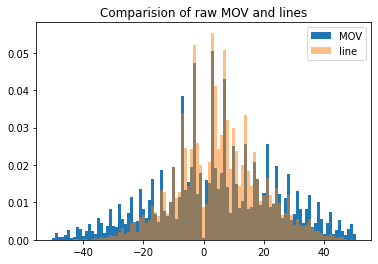

In [70]:
bins = np.linspace(-50.5,50.5,102)
mov_density = plt.hist(df.mov, bins=bins, label="MOV", density=True)
line_density = plt.hist(df.line, bins=bins, label="line", density=True, alpha=.5)
plt.title("Comparision of raw MOV and lines")
plt.legend()
print("Mean MOV: {}, std: {}".format(df.mov.mean(),df.mov.std()))
print("Mean line: {}, std: {}".format(df.line.mean(),df.line.std()))

We see spikes ever 7 points, as expected, and nice range of both MOVs and lines)

An interesting question is "why does the line and MOV follow different shapes and widths?" 


...But we are actually interested in th distribution of (MOV-line):

Our residual distribution mean: -0.11383132164275411 std: 15.717530749021323


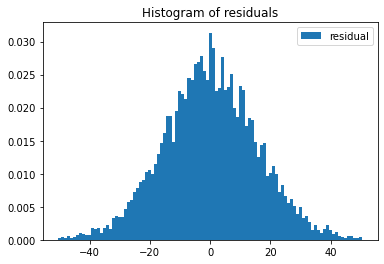

In [71]:
df['residual'] = df.mov-df.line
mov_density = plt.hist(df.residual, bins=bins, label="residual", density=True)
plt.title("Histogram of residuals")
plt.legend()
res_mean = df.residual.mean()
res_std = df.residual.std()
print("Our residual distribution mean: {} std: {}".format(res_mean, res_std))

What we see is a nice, normal (or gaussian) distribution when we subtract the line prediction from MOV. We call this a residual.

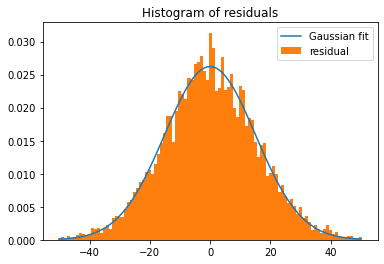

In [73]:
y = mov_density[0]
bin_edge = mov_density[1]
x = np.asarray([(bin_edge[i]+bin_edge[i+1])/2 for i in range(len(bin_edge)-1)])
popt, pcov = curve_fit(gauss,x,y)
y_pred = gauss(x,*popt)
norm,sigma,_ = popt
plt.plot(x,y_pred, label="Gaussian fit")
mov_density = plt.hist(df.residual, bins=bins, label="residual", density=True)
plt.title("Histogram of residuals")
plt.legend()

See how well that Gaussian fits! What this means is that in general, if the line is -10, then we expect the final MOV to be a Gaussian centered at +10 (the line is opposite of the MOV), with a ~16 point width:

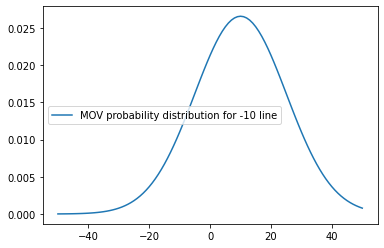

In [84]:
y_pred_m_10 = gauss(x,norm,sigma,+10.)
total_integral = np.sum(y_pred_m_10)
y_pred_m_10 = y_pred_m_10/total_integral
plt.plot(x,y_pred_m_10, label="MOV probability distribution for -10 line")
plt.legend()

For the underdog away team to win in this example, we need MOV < 0

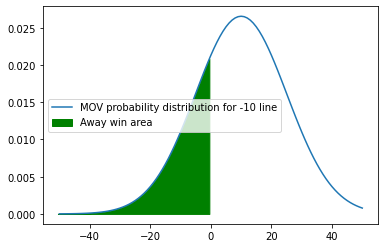

In [93]:
x_away_win = np.linspace(-50.5,-0.5,51)
y_away_win = gauss(x_away_win,norm,sigma,10)/total_integral
plt.plot(x,y_pred_m_10, label="MOV probability distribution for -10 line")
plt.fill_between(x_away_win,y_away_win, label="Away win area", color='green')
plt.legend()

That area cooresponds to the probability that the underdog wins! So, we just sum up each point and divide by the total area to get the realtive size of the green region compared to the whole curve. 

In [94]:
np.sum(y_away_win)/total_integral

0.2576395435592544

So, about a 25% win chance!

What about 14 point?

In [95]:
np.sum(gauss(x_away_win,norm,sigma,14))/total_integral

0.17710375338149162

So ~18% in this chance.

This whole procedure is just integrating a Gaussian from -inifity to 0, so it is equivalent to:

Erf(0, mean=14, scale=16), where Erf=="error function", which is just a fancy name for the integral of a Gaussian distribution. 


...Now, you might have realized that since we have a dataset, we can actually look at games that have a 14 point spread and just check what the win rate is! Lets do that

In [118]:
#select for games with at 14 point line
mov_14 = df[df.line==14].mov.to_numpy()
underdog_won_func = lambda x: x<0
underdog_won = list(map(underdog_won_func,mov_14))

#what we have created is a list of games, where games that the underdog wins is marked as 1, and where the favorite wins is marked as 0
#so sum of that list = number of games the underdog wins, the total length of the list is the number of games
#and the division is the probability that the underdog won
nUnderdogWins = np.sum(underdog_won)
nGames = len(underdog_won)
chance_win = nUnderdogWins/nGames
uncertainty = math.sqrt(nUnderdogWins)/nGames

print("Underdogs win {:.2f}% +- {:.2f}%".format(chance_win*100, uncertainty*100))

Underdogs win 16.08% +- 2.51%


16% +/- 2.5% is within our undertainty of 17.7%, so it looks like things check out!

Lets do one last thing and print out the predicted win % chance vs the actual one for different spreads.

In [180]:
def get_win_p(lines):
  movs = df[df.line==lines].mov.to_numpy()
  underdog_won = list(map(underdog_won_func,movs))
  nUnderdogWins = np.sum(underdog_won)
  nGames = len(underdog_won)
  chance_win = nUnderdogWins/nGames
  uncertainty = math.sqrt(nUnderdogWins)/nGames
  return chance_win, uncertainty, nGames

def predicted_win_p(lines):
  x_away_win = np.linspace(-100,0,101)
  return np.sum(gauss(x_away_win,norm,sigma,lines))

In [ ]:
    self.f, self.axs = plt.subplots(2,1, sharex=True, sharey=False, gridspec_kw={'height_ratios': [4, 1]}, figsize=figsize) 


Text(0.5, 0, 'ratio of observed/predicted')

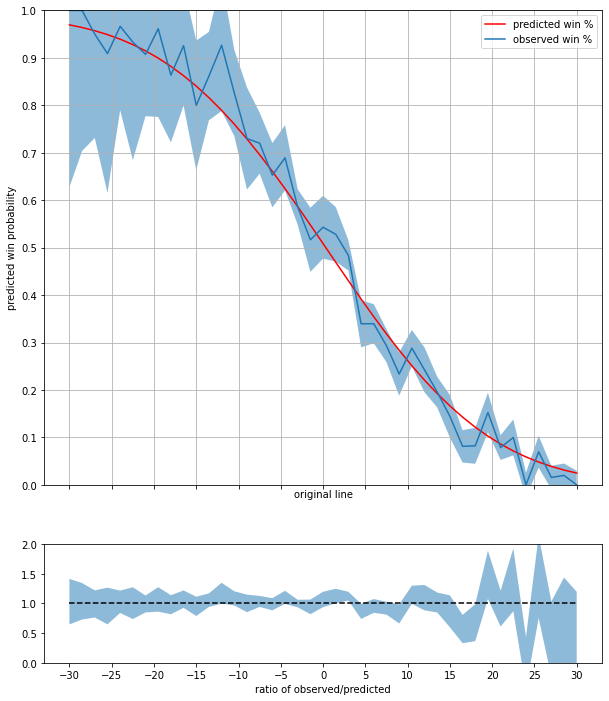

In [185]:
lines = np.linspace(-30,30,41)

observed_win_percentages = list(map(get_win_p, lines))

predicted_wins = list(map(predicted_win_p, lines))
obs_win,obs_unc,nGames = np.asarray(list(zip(*observed_win_percentages)))

kernel_unc = np.sqrt(predicted_wins*nGames)/nGames

obs_win_up,obs_win_down = obs_win+kernel_unc,obs_win-kernel_unc

f,axs = plt.subplots(2,1, sharex=True,sharey=False,gridspec_kw={'height_ratios':[4,1]},figsize=(10,12))
axs[0].plot(lines,predicted_wins,color="red", label='predicted win %')
axs[0].plot(lines,obs_win, label="observed win %")
axs[0].fill_between(lines,obs_win_up,obs_win_down,alpha=.5)
axs[0].set_xlabel("original line")
axs[0].set_ylabel("predicted win probability")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_xticks(np.linspace(-30,30,13))
axs[0].set_yticks(np.linspace(0,1,11))
axs[0].grid(b=True)

ratio = obs_win/predicted_wins
ratio_unc = kernel_unc/predicted_wins

axs[1].set_ylim(0,2)
axs[1].plot(lines,np.full(len(lines),1), color='black', linestyle="dashed")
axs[1].fill_between(lines,ratio+ratio_unc,ratio-ratio_unc, alpha=.5)
axs[1].set_xlabel('ratio of observed/predicted')
